In [24]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
from astropy import coordinates as coord
from scipy.optimize import curve_fit
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
import matplotlib.colors as mplcolors

sjoertpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares'

## TO DO
* Maak een GitHub aan voor overzicht met een README!

* In de Python file met alle functies, hou de clean functies en de file structure functies in aparte documenten voor future use.
    * Docstring de functies

* Gaussian Rise fitten aan iig de r (maar kan ook g en r tegelijk) nadat je de piek van een plot hebt gevonden en exponential decay (zie artikelen van Sjoert voor equations)

* Cleaning verbeteren - je wilt een clean file met alle filters

* Fitting procedure
    * Simple Gaussian peak finder on integral-normalized data -> now peak normalized (still works)
    * Find the peaks in the inverted-chi^2 landscape and note how far away the relevant peaks are (scipy.find_peaks, evt flooding algorithms)
    * Using this found peak, fit the piecewise function of rise and decay to the data w/ good initial guesses
    * Try out bayesian blocks for the possibility of multiple peaks.

* Bayesian blocks
* LEES DE PAPERS!!!

_______________________________________________________________________________________________________________________________

* Fit G en R samen, bewaar de waarde van chi^2 en dof (aantal data punten - extra parameters) en de parameters + errors
    * Noem sigma_dec sigma_rise en tau tau_dec

* Maak in de cleaning er maar 1 file van, mag zelf weten of dat geordend is op filter of op tijd
* Zet de ZTF naam in de filename en de log, maak in de log ook duidelijk wat de baseline van de reference is en per filter HOEVEEL data weg is (niet precies welke!)
* Zet ook welke fields je hebt weggehaald omdat het niet de primaries en hoeveel dat er per field zat

* Methode voor Cleaning: log_dict = {}
    * log_dict['g'] = {} # ook weer een dict
    * log_dict['g']['field_id'] = {'#removed':...,'primary_field':boolean,'#raw data points':,'chi2':} met chi2 alleen een waarde als primary_field
    * dump dit geheel in een json file met indent (onderzoek)
    * Sla ook de median chi op (we hebben de fout vermenigvuldigd met de wortel van dit getal).

* Clip de F_error op [1%,10^99%] van F, dus als de fout kleiner is dan 1% zetten we m op 1%.
* Geef aan curve_fit ook de errors op de flux mee (deze arg heet sigma).

* plot de lightcurves op een verticale manier (3 plots boven elkaar: g, r, i - maak de kleuren ook de kleur van de filter (i bruin)). Zet hier ook de uncleaned data in in het grijs met lage zorder en alpha
    * save de plots in hun bijbehorende folder. Zo heb je maar 1 png per folder.

* Bij het peak finden willen stellen dat de piek op zijn laatst in juli 2022 ligt. Met een tijdstap van 5 dagen. (maak dus van de chi2 zoektoch ook een arange/linspace ipv de datapunten)/

* Anomaly detection?? Local Outlier Factor? Isolation Forest?

In [3]:
PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)
DATAPATH = os.path.join(PATH,'Data')
CODEPATH = os.path.join(PATH,'Code')
columns = ['sindex', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
dtypes = [(columns[x],float) for x in range(len(columns))]
dtypes[4] = ('filter',r'U8')


In [13]:
testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\ZTF18abjjkeo_clean_data.json'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aauosxv\clean_ZTF_r_batchfp_req0000338734_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aavummp\clean_ZTF_r_batchfp_req0000338750_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aajupnt\clean_ZTF_r_batchfp_req0000338755_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\clean_g_and_rbatchfp_req0000338730_lc.txt'


ztf_name = os.path.split(testpath)[-1]

# testfile = r'clean_ZTF_r_batchfp_req0000338730_lc.txt'
testdata = pd.read_json(testpath)
i_filter = testdata['filter'] != 'ZTF_i'
testdata = testdata[i_filter]

time = testdata['time']
flux,err = fp.flux_jy(testdata)
flux = flux.values
maxtime = time.iloc[np.argmax(flux)]
maxflux = np.max(flux)

time = time.values
testdata

,time,flux,flux_unc,zeropoint,filter
0,2.458305e+06,6.894336,23.361463,26.0583,ZTF_g
1,2.458309e+06,7.198718,23.276723,26.0003,ZTF_g
2,2.458388e+06,-36.265013,68.095067,26.0926,ZTF_g
3,2.458398e+06,-11.808126,23.477532,26.0165,ZTF_g
4,2.458423e+06,-10.105147,48.999114,26.1184,ZTF_g
...,...,...,...,...,...
880,2.460083e+06,26.848243,26.475627,26.1103,ZTF_r
881,2.460085e+06,9.539994,24.418736,26.1585,ZTF_r
882,2.460087e+06,-55.485153,23.654849,26.1293,ZTF_r
883,2.460098e+06,-43.619777,52.505503,26.1839,ZTF_r


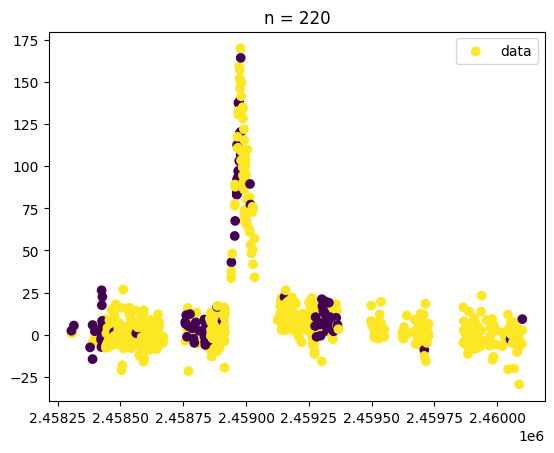

In [14]:
from sklearn.neighbors import LocalOutlierFactor 

for n in [220]:
    LOF = LocalOutlierFactor(n_neighbors=n)
    X = np.reshape([time,flux],(time.shape[0],2))
    preds = LOF.fit_predict(X)

    plt.figure()
    plt.title(f"n = {n}")
    plt.scatter(time,flux,c=preds,label='data')
    plt.legend()
    plt.show()

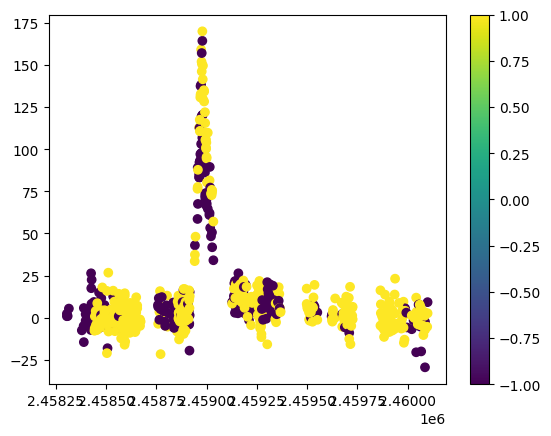

In [15]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest()
preds_if = IF.fit_predict(X)

fig = plt.figure()
im =plt.scatter(time,flux,c=preds_if,label='')
fig.colorbar(im)
# plt.legend()
plt.show()

## Fitting

[2.06900629e+01 3.37474009e+01 3.02169266e-02] [3.37280429e+00 3.15621935e+00 7.79293598e-07] 
relative error:  [1.63015661e-01 9.35248129e-02 2.57899690e-05]


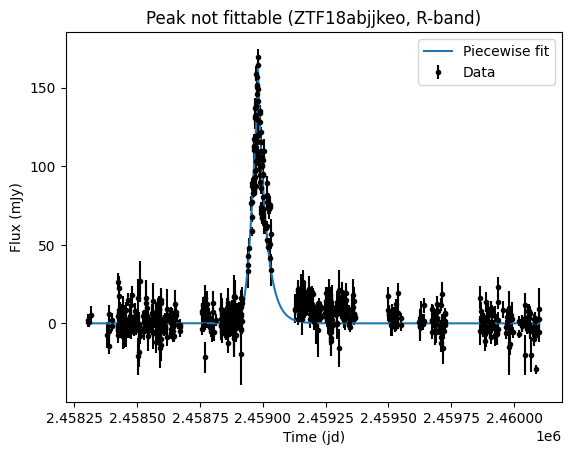

In [16]:
time = testdata['time']
flux,err = fp.flux_jy(testdata)
maxtime = time.iloc[np.argmax(flux)]
maxflux = np.max(flux)

def gauss(x,a,b,c,d):
    return a * np.exp(-(np.square(x-b)/(2*c**2)))

def exp_decay(x,a,b,c,d):
    return a * np.exp(-b * x)

def gauss_exp_comb(x,b,c,d):
    #xrel = x - max_time
    #masks zijn dan xrel <=0 en x >0
    #eigenlijk beter: def model(x, *p) dan kan p gewoon een array van arbitraire lengte.
    #verder in log: tau = 10^(p[1]) en je kan bounds geven, tau is ipc rond de 10
    #sigma_dec = 10^(p[2])
    #Fp = 10^(p[3]) maakt niet uit of dit 10 of e of 3 is, 10 is robuuster (intuitiever)
    #ook nog een offset parameter meegeven zodat waardes <0 ook meegenomen worden 
    #alpha: spectral index is p[5]  
    # dus niet return zoals hieronder maar dat gaat in z'n geheel nog keer (v_i/v_0)^alpha en v_i is een array van centrals van g of r maar dat is verschillend 
    #per datapunt - elk datapunt heeft een tijd en bijbehorende filter (waar die vandaan komt) en zo kan je v_i construeren.
    #uiteindelijk zijn dus fittable: 6 parameters. alpha is te interpreten als - phot. kleur (met een factor 2.5 ergens van de magnitudes). Alpha /> 2 (dat is BB) of arbitrair negatief
    #zijn
    #zet ook een condition dat alpha niet gefit wordt als v_i bestaat uit alleen maar dezelfde waarde (ofwel je fit maar in 1 band)
    #ADDENDUM/ERRATUM: we gaan weg van alpha en doen het anders. We pakken B_v(T)/B_v_0(T) waar en v_0 is je referentie 0 (tussen r en g). Zet bound op temperatuur van 1000K > T > 10^5 K
    #Verder: T = 10^(p[5])
    #robuust piek vinden: google robust peak finding. je kan ook driehoek (10 dagen rise, 10 dagen decay bv) fitten en de beste chi^2 vinden

    return np.piecewise(x,[x <= 0,x>0],[lambda x:maxflux * np.exp(-(np.square(x-b)/(2*c**2))), lambda x:maxflux * np.exp(-d * x)])

popt,pcov = curve_fit(gauss_exp_comb,time.values-time.iloc[np.argmax(flux)],flux.values,p0=[1,1,1e-2]) 
moretimes = np.linspace(min(time),max(time),1000) 
fit = gauss_exp_comb(moretimes-time.iloc[np.argmax(flux)],*popt)

print(popt,np.diagonal(pcov),'\nrelative error: ',np.diagonal(pcov)/popt)

plt.errorbar(time,flux,err,fmt='.',c='black',label='Data')
plt.plot(moretimes,fit,label='Piecewise fit')
plt.xlabel("Time (jd)")
plt.ylabel("Flux (mJy)")
plt.title("Peak not fittable (ZTF18abjjkeo, R-band)")
plt.legend()
plt.show()

Popt: ['log10(Fp) = 2.083272287128186', 'peak_position = 2458978.149408837', 'log10(sigma_dec) = 1.3292130496718542', 'log10(tau) = 1.8197260506102155', 'F0 = 3.0912811417385395', 'log10(T) = 3.967621382044709'] 
Errors [3.77758375e-05 8.99337112e-01 8.38797108e-04 4.87196290e-04
 2.30779822e-01 1.21990438e-04] 
Relative error:  [1.81329333e-05 3.65736113e-07 6.31047903e-04 2.67730568e-04
 7.46550737e-02 3.07464917e-05]


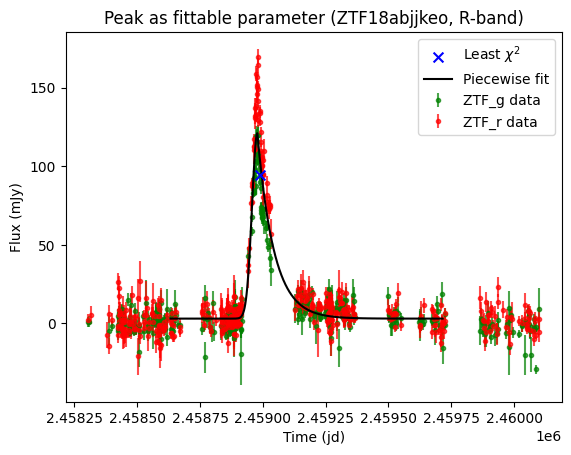

90052.26341342536


In [56]:
from scipy.constants import h,c,k
def BB(nu,T):
    #Blackbody spectrum for a certain frequency given in Hz, not an array of values
    factor = 2*h*nu**3/(c**2)
    exponent = (h*nu)/(k*T)
    return factor /(np.exp(exponent)-1)


#Source: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=Palomar&gname2=ZTF&asttype=
g_center = c/ (4746.48 * 1e-10)
r_center = c / (6366.38 * 1e-10)

def BB_ratio(T,shape):
    v0 = (g_center + r_center) / 2
    # amount = 420 #this is a random number now, for amount of alternating values. This should become the amount of green data points and amount of red
    v1 = np.empty((shape,))
    v1[::2] = g_center
    v1[1::2] = r_center
    exp1 = np.exp((h*v0)/(k*T)) 
    exp2 = np.exp((h*v1)/(k*T)) 
    return v1**3 * (exp1 - 1) / (v0**3 * (exp2 - 1))

#DIT GEEFT ERRORS MET DE 10^ TRUC - NAMELIJK DAT DE RESIDUALS OP DE INTIAL NIET FINITE ZIJN.
def gauss_exp_fit(t,*p):
    Fp = 10**p[0]
    peak_position = p[1]
    sigma_dec = 10**p[2]
    tau = 10**p[3]
    F0 = p[4]
    T = 10**p[5]

    trel = t - peak_position
    gaussian = lambda t: Fp * np.exp(-(np.square(t-peak_position)/(2*sigma_dec**2))) + F0
    exp_decay = lambda t: Fp * np.exp(-(t-peak_position)/tau) + F0
    
    trel2 = t - t[np.argmin(gaussian(t)-Fp)]
    # print(trel2)
    function = np.piecewise(t,[trel <= 0,trel>0],[gaussian, exp_decay])
    return function * BB_ratio(T,function.shape[0])

# guesses = np.log10([np.max(flux),maxtime,1,1e-2,1,1e4])
chi2_results, peak_ind = fp.chi2_peak_finder(flux,err,time,normalized=False)


time_mask = (time.values > (time[peak_ind] -365)) & (time.values < (time[peak_ind]+365*2))

time_arr = time.values


guesses = [np.log10(np.max(flux)),time[peak_ind],1,2.5,1,4] #Fp, peak_pos, sigma, tau, F0, T
boundings = ([1,time[peak_ind]-100,0,0,0,3],[np.log10(np.max(flux*2)),time[peak_ind]+100,4,4,np.median(flux),5]) #Fp, peak_pos, sigma, tau, F0, T

popt,pcov,info_dict,_,_ = curve_fit(gauss_exp_fit,time_arr[time_mask],flux[time_mask],p0=guesses,bounds=boundings,sigma=err[time_mask],
                                    full_output=True) 

names = ["log10(Fp)","peak_position","log10(sigma_dec)","log10(tau)","F0","log10(T)"]
display = [f"{names[i]} = {opt}" for i,opt in enumerate(popt)]

print("Popt:",display,'\nErrors',np.diagonal(pcov),'\nRelative error: ',np.diagonal(pcov)/popt)
moretimes = np.linspace(min(time_arr[time_mask]),max(time_arr[time_mask]),821) 
fit = gauss_exp_fit(moretimes,*popt)

greenmask = (testdata['filter'] == 'ZTF_g').values
plt.errorbar(time[greenmask],flux[greenmask],err[greenmask],fmt='.',c='green',label='ZTF_g data',zorder=-1,alpha=0.7)
plt.errorbar(time[~greenmask],flux[~greenmask],err[~greenmask],fmt='.',c='red',label='ZTF_r data',zorder=-1,alpha=0.7)
# plt.scatter(time,flux,s=5,c='black',label='Data')
plt.scatter(time[peak_ind],flux[peak_ind],s=50,marker='x',c='blue',zorder=10,label=r'Least $\chi^2$')
# plt.scatter(popt[1],10**popt[0],s=50,marker='x',c='black',zorder=10,label=r'Fitted peak',alpha=0.9)

plt.plot(moretimes,fit,label='Piecewise fit',zorder=9,c='black')
# plt.vlines(popt[1],0,150,label='Found peak',colors='red')
plt.xlabel("Time (jd)")
plt.ylabel("Flux (mJy)")
plt.title("Peak as fittable parameter (ZTF18abjjkeo, R-band)")
plt.legend()    
plt.show()

print(fp.chi2(flux,err,model_fit=gauss_exp_fit(moretimes,*popt)))

In [19]:
info_dict['nfev']

10